# Подготовка

In [9]:
import csv
import glob
import yaml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display, Markdown as md
from collections import OrderedDict
from datetime import datetime
from scrapinghub import ScrapinghubClient

In [10]:
# загружаем конфиг
with open('config.yaml') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

# Загрузка данных

Данные выгружаются напрямую из Scrapinghub по API. Нужный датасет (или даже нужные датасеты, их можно быть много) ищутся по их тегу. Чтобы все работало, в конфиге тулбокса (файл `config.yaml`) нужно в параметре `category_positions:job_tag_filter` указать название тэга выгрузки Scrapinghub, по которой нужно выгружать данные. Скрипт выгрузит результаты работы всех завершенных задач с указанным тегом. Тег в Scrapinghub нужно указать при создании выгрузки данных (job).

Помимо этого в конфиге (файл `config.yaml`) в поле `seller:sku_list` должны быть перечислены Wildberries артикулы всех товаров, позиции которых нужно отслеживать.

Дальше этот датасет будет сохранен в папку data директории, в которой находится блокнт. Если в папке уже лежит файл с названием вида `category_positions_*.csv`, то новые данные загружены не будут.

Нужный файл можно положить и вручную, скачав его из Scrapinghub. Можно даже положить несколько файлов – скрипт возьмет последний по алфавиту.

После изменения переменной с тегом в Юпитере нужно выбрать пункт меню "Run -> Run All Cells". Дальше блокнот сделает все сам.

In [11]:
# здесь нужно указать тэг нужной выгрузки, по-умолчанию он берется из конфига
job_tag_filter = config['category_positions']['job_tag_filter']

# остальное лучше не трогать
api_key = config['scrapinghub']['api_key']
project_id = config['scrapinghub']['project_id']
csv_name =  './data/category_positions_' + str(datetime.now()) + '.csv'
item_ids = sorted(config['seller']['sku_list'])

def load_data(job_tag_filter, api_key, project_id, csv_name):
    client = ScrapinghubClient(api_key)
    project = client.get_project(project_id)
    fieldnames = []
    
    jobs_summary = project.jobs.iter(has_tag=[job_tag_filter], state='finished')
    
    # определяем поля выгрузки
    for job in jobs_summary:
        for item in client.get_job(job['key']).items.iter():
            fieldnames = item.keys()
            break
        break
    
    # готовим CSV
    with open(csv_name, 'w') as csvfile:
        fieldnames = ['parse_date'] + item_ids
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

        writer.writeheader()

        # собираем выгрущки по тегу evossa_10_min
        jobs_summary = project.jobs.iter(has_tag=[job_tag_filter], state='finished')

        for job in jobs_summary:
            # все даты в API отдаются в виде таймстемпов в миллисекундах
            job_time = datetime.utcfromtimestamp(job['running_time']/1000.0).strftime('%Y-%m-%d %H:%M:%S')

            print("Фильтруем выгрузки по тэгу {}".format(job_tag_filter))
            
            print("Пишем данные выгрузки от {}".format(str(job_time)))
            
            positions = {}

            for item in client.get_job(job['key']).items.iter():
                item_id = int(item['wb_id'])

                if item_id in item_ids:
                    positions[item_id] = item['wb_category_position']

            positions['parse_date'] = job_time

            writer.writerow(positions)

load_data(job_tag_filter, api_key, project_id, csv_name)

Фильтруем выгрузки по тэгу evossa
Пишем данные выгрузки от 2020-01-17 20:00:29
Фильтруем выгрузки по тэгу evossa
Пишем данные выгрузки от 2020-01-16 20:00:29
Фильтруем выгрузки по тэгу evossa
Пишем данные выгрузки от 2020-01-15 20:00:36
Фильтруем выгрузки по тэгу evossa
Пишем данные выгрузки от 2020-01-14 20:00:29
Фильтруем выгрузки по тэгу evossa
Пишем данные выгрузки от 2020-01-13 20:00:31
Фильтруем выгрузки по тэгу evossa
Пишем данные выгрузки от 2020-01-12 20:00:26
Фильтруем выгрузки по тэгу evossa
Пишем данные выгрузки от 2020-01-11 20:00:29
Фильтруем выгрузки по тэгу evossa
Пишем данные выгрузки от 2020-01-10 20:00:28
Фильтруем выгрузки по тэгу evossa
Пишем данные выгрузки от 2020-01-09 20:00:26
Фильтруем выгрузки по тэгу evossa
Пишем данные выгрузки от 2020-01-08 20:00:29
Фильтруем выгрузки по тэгу evossa
Пишем данные выгрузки от 2020-01-07 20:00:27
Фильтруем выгрузки по тэгу evossa
Пишем данные выгрузки от 2020-01-06 20:00:25
Фильтруем выгрузки по тэгу evossa
Пишем данные выгру

In [12]:
pd.set_option("display.precision", 2)

latest_csv = sorted(glob.glob('./data/category_positions_*.csv'), reverse=True)[0]
data = pd.read_csv(latest_csv, index_col=['parse_date'], parse_dates=['parse_date'], dayfirst=False)

# Анализ позиций

## Позиции всех запрошенных SKU

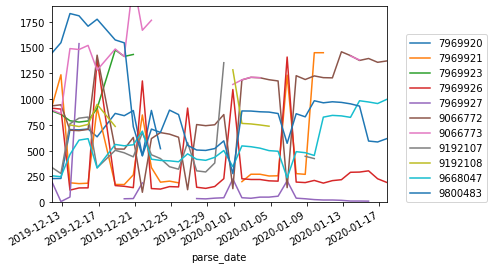

In [13]:
ax = plt.gca()

data.plot(kind='line', ax=ax)
        
plt.setp(ax.get_xticklabels(), rotation=30, ha="right")
plt.legend(bbox_to_anchor=(1.3, 0), loc='lower right', borderaxespad=0.)
plt.ylim(0, 1900)

plt.show()

## Позиции с нейтральной и изменяющейся динамикой

No handles with labels found to put in legend.


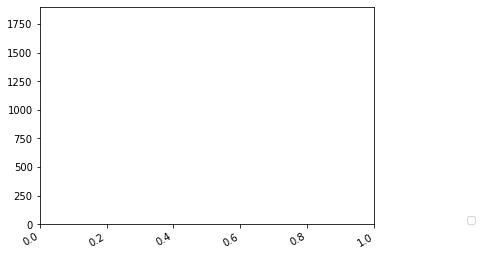

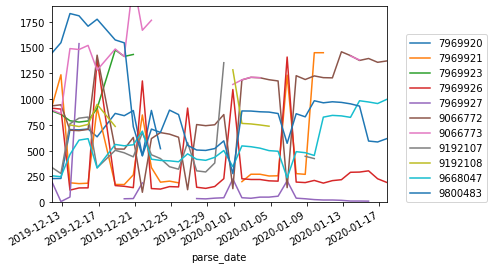

In [14]:
std_threshold = 100

ax = plt.gca()

for column in data.columns:
    if data[column].std() < std_threshold:
        data.plot(kind='line', y=str(column), ax=ax)
        
plt.setp(ax.get_xticklabels(), rotation=30, ha="right")
plt.legend(bbox_to_anchor=(1.3, 0), loc='lower right', borderaxespad=0.)
plt.ylim(0, 1900)

plt.show()

ax = plt.gca()

for column in data.columns:
    if data[column].std() > std_threshold:
        data.plot(kind='line', y=str(column), ax=ax)
        
plt.setp(ax.get_xticklabels(), rotation=30, ha="right")
plt.legend(bbox_to_anchor=(1.3, 0), loc='lower right', borderaxespad=0.)
plt.ylim(0, 1900)

plt.show()

## Позиции с выбросами вверх и выбросами вниз

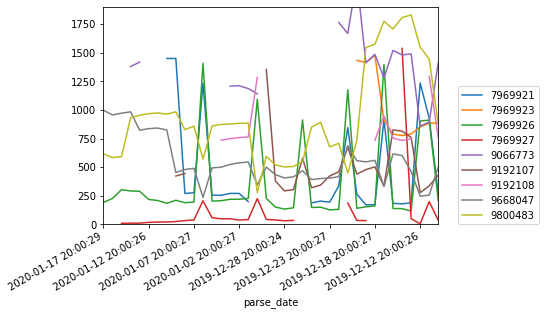

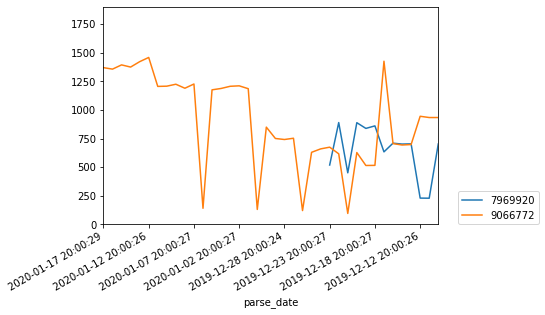

In [15]:
podskok = data[data.std(axis=1) > std_threshold].copy()

# транспонируем для удобства работы, потом вернем все обратно
podskok_T = podskok.transpose()

# вычисляем максимальный выброс и его сторону
podskok_T['median'] = podskok_T.median(axis=1)
podskok_T['max_upper'] = podskok_T.max(axis=1) - podskok_T.median(axis=1)
podskok_T['max_lower'] = podskok_T.median(axis=1) - podskok_T.min(axis=1)
podskok_T['max_diff'] = podskok_T[['max_upper', 'max_lower']].max(axis=1)
podskok_T['max_diff_idx'] = podskok_T[['max_upper', 'max_lower']].idxmax(axis=1)

# делим датасет на две части
podskok_T_upper = podskok_T[podskok_T['max_diff_idx']=='max_upper']
podskok_T_lower = podskok_T[podskok_T['max_diff_idx']=='max_lower']

# удаляем вспомогательные столбцы, чтобы транспонировать обратно
del(podskok_T_upper['max_upper'])
del(podskok_T_upper['max_lower'])
del(podskok_T_upper['max_diff'])
del(podskok_T_upper['max_diff_idx'])

del(podskok_T_lower['max_upper'])
del(podskok_T_lower['max_lower'])
del(podskok_T_lower['max_diff'])
del(podskok_T_lower['max_diff_idx'])

# транспонируем обратно и возвращаем даты
podskok_upper = podskok_T_upper.transpose()
podskok_lower = podskok_T_lower.transpose()

# строим графики
ax = plt.gca()

podskok_upper.plot(kind='line', ax=ax)
        
plt.setp(ax.get_xticklabels(), rotation=30, ha="right")
plt.legend(bbox_to_anchor=(1.3, 0), loc='lower right', borderaxespad=0.)
plt.ylim(0, 1900)

plt.show()

ax = plt.gca()

for column in podskok_lower.columns:
    if column != '7969923':
        podskok_lower.plot(kind='line', y=str(column), ax=ax)
        
plt.setp(ax.get_xticklabels(), rotation=30, ha="right")
plt.legend(bbox_to_anchor=(1.3, 0), loc='lower right', borderaxespad=0.)
plt.ylim(0, 1900)

plt.show()

# Средняя позиция по всем товарам

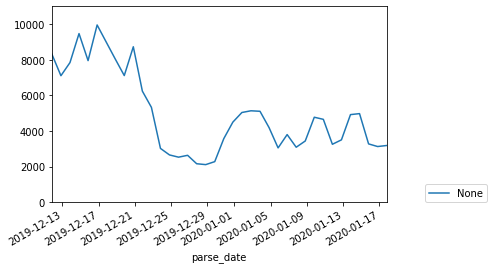

In [16]:
ax = plt.gca()

data.sum(axis=1).plot(kind='line')
plt.setp(ax.get_xticklabels(), rotation=30, ha="right")
plt.legend(bbox_to_anchor=(1.3, 0), loc='lower right', borderaxespad=0.)
plt.ylim(0, 11000)

plt.show()